# Class 18: Dynamics on Networks 3 — Agent-Based Models

Goal of today's class:
1. Extend notion of dynamics on networks to agent-based models
2. Introduce Elementary Cellular Automata, the Voter Model and Schelling model
3. Explore ABMs on your own

__________

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_18/ folder.
________

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

## Introduction to Agent-Based Models (ABMs)

Agent-Based Models (ABMs) are tools for exploring how individual actions and interactions can create large-scale, macroscopic phenomena. These "agents"—whether they’re people, animals, cells, or even abstract entities—follow simple rules that dictate how they behave and interact within a specific environment. By modeling these behaviors, we can uncover how larger trends and phenomena emerge from the ground up. ABMs have applications everywhere: understanding social dynamics, tracking the spread of diseases, modeling economies, studying ecosystems, and even exploring physical systems.

What makes ABMs so fascinating is their ability to show **emergence**: how complex, unexpected patterns can arise from simple, local interactions. This concept is key for understanding systems that are too complex to tackle with traditional approaches—systems where the whole is much more than the sum of its parts.

In this chapter, we’ll kick off our exploration into ABMs through one of the simplest and most famous examples: Elementary Cellular Automata (ECA). These models, though incredibly basic, highlight the core ideas of emergence and complexity. They’re a great place to start as we work our way toward more advanced agent-based models.

---

### Elementary Cellular Automata as "Agents"

Cellular automata (CAs) are discrete models composed of cells arranged in a grid, where each cell evolves over time according to a set of simple, local rules. Despite their simplicity, cellular automata demonstrate a wide range of behaviors, from static or periodic structures to chaotic dynamics, depending on the rules governing them. This makes them a natural precursor to more advanced ABMs, as they allow us to:

1. **Isolate Fundamental Principles**: By focusing on abstract, rule-based systems, we can explore how local interactions create global patterns without the complexity of real-world data.
2. **Visualize Emergence**: Cellular automata are highly visual, making it easy to see the progression of states and the emergence of patterns over time.
3. **Transition to ABMs**: The framework of CAs, with their discrete states and local rules, closely parallels the logic underlying ABMs, where agents operate according to simple rules within an environment.

![](images/nks.png)

________
### Elementary Cellular Automata: A Foundation for Complexity

**Elementary Cellular Automata (ECA)** (Wolfram, 1983) are among the simplest forms of cellular automata. They typically consist of:
- A one-dimensional grid of cells, each of which can be in one of two states: `0` (inactive) or `1` (active).
- A **rule** that determines the next state of a cell based on its current state and the state of its two immediate neighbors.

Each of the 256 possible rules (numbered from 0 to 255) corresponds to a unique set of dynamics. These rules encode the behavior of the system, and through them, we can observe how complexity emerges from simplicity. For example:
- Some rules result in stable or periodic patterns, such as Rule 90, which generates fractal-like structures.
- Other rules, such as Rule 110, exhibit chaotic dynamics and even computational universality, meaning they can emulate any Turing machine.

![](images/eca_rules.png)

Image credit: *New Scientist* (2002), "The Book of Revelation" https://www.newscientist.com/article/mg17523506-000-the-book-of-revelation/

**Some good references if you want to explore more:**
1. Wolfram, S. (2002). A New Kind of Science. Champaign, IL: Wolfram Media.
2. Wolfram, S. (1983). Statistical mechanics of cellular automata. *Reviews of Modern Physics*, 55(3), 601–644. https://doi.org/10.1103/RevModPhys.55.601
3. Wolfram, S. (1984). Universality and complexity in cellular automata. *Physica D: Nonlinear Phenomena*, 10(1-2), 1–35. https://doi.org/10.1016/0167-2789(84)90245-8

In [2]:
def rule_to_bin(rule_number):
    """
    Converts the rule number (0-255) into an 8-bit binary representation.
    
    Args:
        rule_number (int): Rule number (0-255) defining the behavior of the cellular automaton.
    
    Returns:
        np.ndarray: An array of 8 binary digits representing the rule.
    """
    return np.array([int(x) for x in np.binary_repr(rule_number, width=8)], dtype=int)



def apply_rule(state, rule_bin, p=0):
    """
    Applies the rule to compute the next state of the cellular automaton.
    
    Args:
        state (np.ndarray): The current state of the automaton as a 1D array.
        rule_bin (np.ndarray): The binary representation of the rule.
        p (float): Probability of flipping a cell's state (0 to 1 or 1 to 0).
    
    Returns:
        np.ndarray: The next state of the automaton as a 1D array.
    """
    next_state = np.zeros_like(state)  # Initialize the next state
    for i in range(1, len(state) - 1):  # Exclude boundaries
        # Extract the 3-cell neighborhood
        neighborhood = state[i-1:i+2]
        # Calculate the rule index for the neighborhood
        idx = 7 - (neighborhood[0] * 4 + neighborhood[1] * 2 + neighborhood[2])
        next_state[i] = rule_bin[idx]  # Apply the rule
        
        # Randomly toggle the cell state based on probability p
        if np.random.rand() < p:
            next_state[i] = 1 - next_state[i]

    return next_state



def run_automaton(rule_number, size, steps, initial_state=None, p=0):
    """
    Runs the elementary cellular automaton for a given rule number and parameters.
    
    Args:
        rule_number (int): The rule number (0-255) to define the automaton's behavior.
        size (int): The number of cells in the grid.
        steps (int): The number of time steps to simulate.
        initial_state (np.ndarray, optional): The initial state of the automaton. Defaults to a single active cell in the center.
        p (float): Probability of flipping a cell's state during evolution.
    
    Returns:
        np.ndarray: A 2D array where each row represents the state of the automaton at a given time step.
    """
    rule_bin = rule_to_bin(rule_number)  # Convert rule number to binary
    state = np.zeros(size, dtype=int)  # Initialize the grid
    
    # Set initial state
    if initial_state is None:
        state[size // 2] = 1  # Single active cell in the center
    else:
        state[:len(initial_state)] = initial_state
    
    states = [state.copy()]  # Store all states for visualization
    
    # Simulate the automaton over the given number of steps
    for _ in range(steps):
        state = apply_rule(state, rule_bin, p)
        states.append(state.copy())
    
    return np.array(states)



def get_full_rule(neighborhood, rule_bin):
    """
    Retrieves the output of the rule for a given neighborhood.
    
    Args:
        neighborhood (list): A list representing the 3-cell neighborhood.
        rule_bin (np.ndarray): The binary representation of the rule.
    
    Returns:
        tuple: The input neighborhood and the corresponding output value.
    """
    # Calculate the rule index for the neighborhood
    idx = 7 - (neighborhood[0] * 4 + neighborhood[1] * 2 + neighborhood[2])
    return neighborhood, rule_bin[idx]



def plot_automaton(states, rule_number):
    """
    Plots the evolution of the cellular automaton over time and visualizes the rule.
    
    Args:
        states (np.ndarray): A 2D array representing the states of the automaton over time.
        rule_number (int): The rule number (0-255) to display in the title.
    """
    rules = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
             [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]  # All possible neighborhoods
    rule_bin = rule_to_bin(rule_number)  # Convert rule number to binary
    
    halfway = int((states.shape[1] - 1) / 2 + 1)  # Find the halfway point of the grid
    
    if states[:, halfway:].sum() > 0:  # Case for wider patterns
        fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)
        ax.imshow(states, cmap='binary', aspect='auto')
        ax.set_xlabel("Cells")
        ax.set_ylabel("Time")
        ax.set_title(f"Elementary Cellular Automaton: Rule {rule_number}", x=1.0, ha='right')
        ax2 = ax.inset_axes([0.75, 0.75, 0.25, 0.25])  # Add inset for rule visualization
    else:  # Case for narrower patterns
        fig, ax = plt.subplots(1, 1, figsize=(12 / 2, 6), dpi=150)
        states = states[:, :halfway-1].copy()
        ax.imshow(states, cmap='binary', aspect='auto')
        ax.set_xlabel("Cells")
        ax.set_ylabel("Time")
        ax.set_title(f"Elementary Cellular Automaton: Rule {rule_number}", x=0.0, ha='left')
        ax2 = ax.inset_axes([0.0, 0.75, 0.5, 0.25])  # Add inset for rule visualization
    
    # Visualize the rule logic in the inset
    gaps = np.linspace(0.045, 1.07, int((len(rules) / 2) + 1))
    for ri, r in enumerate(rules):
        r, rX = get_full_rule(r, rule_bin)
        if ri < 4:
            xvals = np.array([gaps[ri]] * 3) + np.array([0, 0.07, 0.14])
            ax2.scatter(xvals, [0.8] * 3, marker='s', c=r, ec='.5', vmin=0, vmax=1, cmap='Greys', s=80)
            ax2.scatter([xvals[1]], [0.66], marker='s', c=rX, ec='.5', vmin=0, vmax=1, cmap='Greys', s=80)
        else:
            xvals = np.array([gaps[ri - 4]] * 3) + np.array([0, 0.07, 0.14])
            ax2.scatter(xvals, [0.3] * 3, marker='s', c=r, ec='.5', vmin=0, vmax=1, cmap='Greys', s=80)
            ax2.scatter([xvals[1]], [0.16], marker='s', c=rX, ec='.5', vmin=0, vmax=1, cmap='Greys', s=80)
    
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    plt.show()

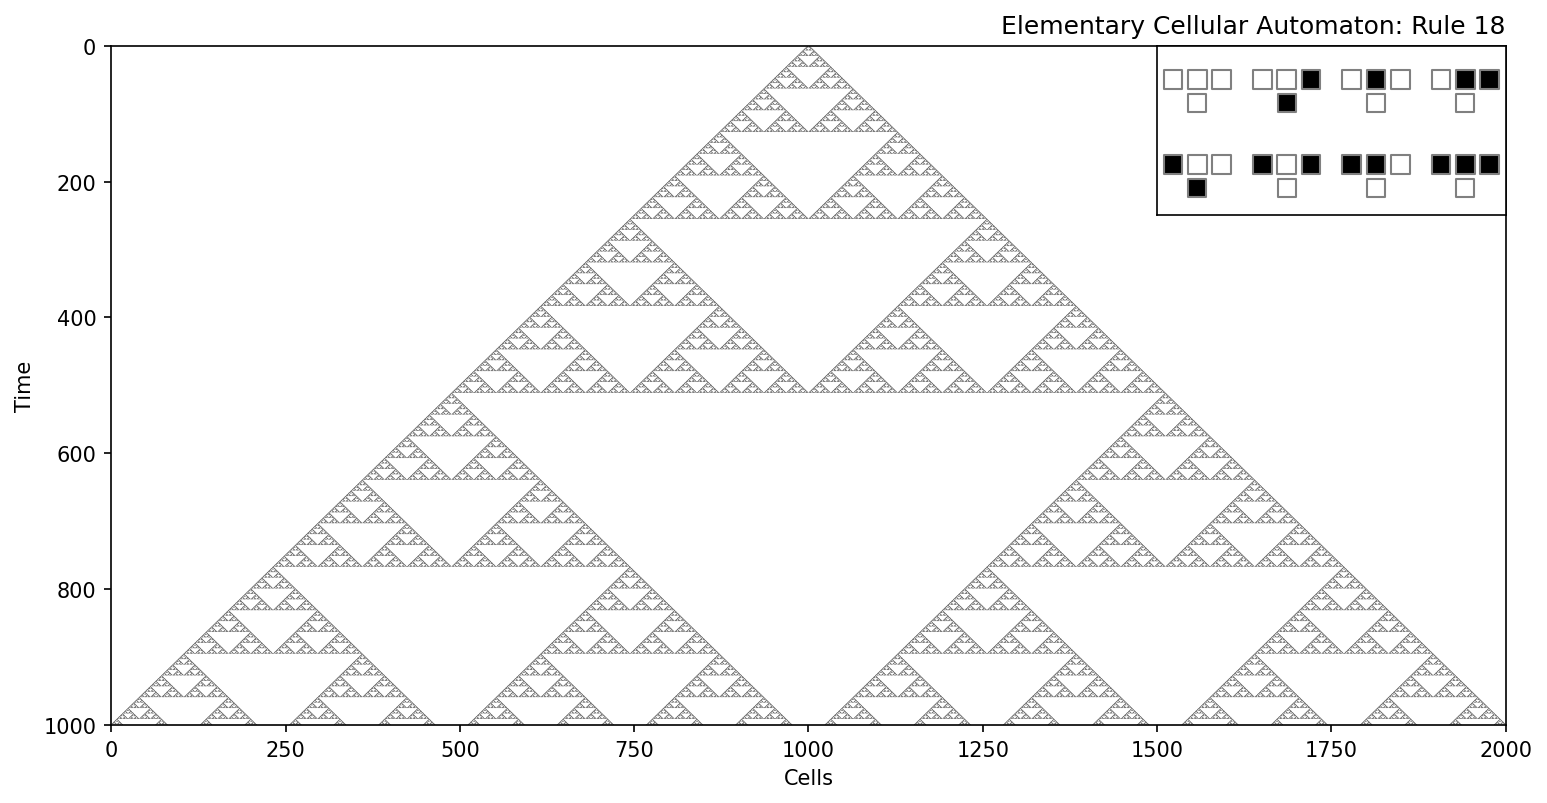

In [3]:
# Example Usage
rule_number = 18  # Choose rule number (0-255)
steps = 1000  # Number of time steps to simulate
size = steps*2+1  # Number of cells in the grid

states = run_automaton(rule_number, size, steps, p=0)
plot_automaton(states, rule_number)

### Your turn! Answer the following:

1. ...wait why are we doing this?
2. Below, play around with a few different rules. What do you notice? Who can find the most interesting rule?
3. ...why is it interesting?

In [4]:
# # Choose rule number (0-255)
# rule_number = 18

# steps = 500  # Number of time steps to simulate
# size = steps*2+1  # Number of cells in the grid

# states = run_automaton(rule_number, size, steps, p=0.0)
# plot_automaton(states, rule_number)

---

### From Cellular Automata to Agent-Based Models

ECAs are probably some of the "simplest" examples of ABMs that demonstrate how simple, rule-based systems can produce "complex" phenomena, providing a foundation for extending to more sophisticated ABMs. While ECAs operate on static grids with fixed rules, ABMs in general can feature dynamic agents with richer behaviors, interactions, and adaptive capacities. The transition from ECAs to ABMs involves:
- Moving from uniform, grid-based systems to heterogeneous environments (i.e., network structure, dynamic environments, etc.).
- Replacing simple state transitions with rule-based decisions made by autonomous agents (i.e., generative models of behavior).

We've already seen several examples of ABMs in class so far!
1. Network growth models can often be cast as an "agentive" process (new nodes "choosing" to add their edges to nodes in the network)
2. Contagion and diffusion models.


Here’s several more common ABM paradigms frequently applied to networks:

3. Opinion Dynamics - models that try to capture agents' opinions evolving through interactions with their neighbors in the network. Agents often update opinions based on averaging, thresholds, or reinforcement (e.g. "Voter" model, "DeGroot" learning model, bounded confidence models, rumor models, etc.)
4. Game-Theoretic Models - modeling *strategic* interactions between agents, where an agent's payoff depends on its own actions and the actions of their neighbors via (usually) repeated interactions (e.g. Prisoner’s dilemma, public goods games, ultimatum games, etc.)
5. Mobility and Spatial Interaction Models - models agents traversing a spatial network and interacting with their environments (e.g., transportation networks)
6. Homophily and Social Influence Models - models that show how rewiring in networks can create homophily, feedback loops, and more (e.g. Axelrod’s cultural dissemination model, models of polarizaiton/echo chambers, etc.)
7. Resource Allocation and Foraging Models - inspired by ants or other optimizing collectives in nature, these models involve agents allocating resources or exploring the network to maximize some payoff function, which often results in tradeoffs between exploration and exploitation.
8. And many many more, of course!


____________
**Some good references:**

1. Clifford, P., & Sudbury, A. (1973). A model for spatial conflict. *Biometrika*, 60(3), 581–588. https://doi.org/10.1093/biomet/60.3.581
2. Holley, R. A., & Liggett, T. M. (1975). Ergodic theorems for weakly interacting infinite systems and the voter model. *Annals of Probability*, 3(4), 643–663. https://doi.org/10.1214/aop/1176996306
3. DeGroot, M. H. (1974). Reaching a consensus. Journal of the American Statistical Association, 69(345), 118–121. https://doi.org/10.2307/2285509
4. Hegselmann, R., & Krause, U. (2002). Opinion dynamics and bounded confidence: Models, analysis, and simulation. *Journal of Artificial Societies and Social Simulation, 5*(3), 1–24. http://jasss.soc.surrey.ac.uk/5/3/2.html
4. Daley, D. J., & Kendall, D. G. (1965). Stochastic rumours. *Journal of the Institute of Mathematics and Its Applications, 1*(1), 42–55. https://doi.org/10.1093/imamat/1.1.42
5. Nowak, M. A., & May, R. M. (1992). Evolutionary games and spatial chaos. *Nature, 359*(6398), 826–829. https://doi.org/10.1038/359826a0
6. Santos, F. C., & Pacheco, J. M. (2005). Scale-free networks provide a unifying framework for the emergence of cooperation. *Physical Review Letters, 95*(9), 098104. https://doi.org/10.1103/PhysRevLett.95.098104
7. Hardin, G. (1968). The tragedy of the commons. *Science, 162*(3859), 1243–1248. https://doi.org/10.1126/science.162.3859.1243
8. Perc, M., & Szolnoki, A. (2010). Coevolutionary games—a mini review. *BioSystems, 99*(2), 109–125. https://doi.org/10.1016/j.biosystems.2009.10.003
9. Güth, W., Schmittberger, R., & Schwarze, B. (1982). An experimental analysis of ultimatum bargaining. *Journal of Economic Behavior & Organization, 3*(4), 367–388. https://doi.org/10.1016/0167-2681(82)90011-7
10. Barthélemy, M. (2011). Spatial networks. *Physics Reports, 499*(1-3), 1–101. https://doi.org/10.1016/j.physrep.2010.11.002
11. Noh, J. D., & Rieger, H. (2004). Random walks on complex networks. *Physical Review Letters, 92*(11), 118701. https://doi.org/10.1103/PhysRevLett.92.118701
12. Axelrod, R. (1997). The dissemination of culture: A model with local convergence and global polarization. *Journal of Conflict Resolution, 41*(2), 203–226. https://doi.org/10.1177/0022002797041002001
13. Pariser, E. (2011). *The Filter Bubble: What the Internet Is Hiding from You.* New York: Penguin Press.
14. Dandekar, P., Goel, A., & Lee, D. T. (2013). Biased assimilation, homophily, and the dynamics of polarization. *Proceedings of the National Academy of Sciences, 110*(15), 5791–5796. https://doi.org/10.1073/pnas.1217220110
15. Bonabeau, E., Dorigo, M., & Theraulaz, G. (1999). Swarm intelligence: From natural to artificial systems. *Oxford University Press*.
16. Goss, S., Aron, S., Deneubourg, J. L., & Pasteels, J. M. (1989). Self-organized shortcuts in the Argentine ant. *Naturwissenschaften, 76*(12), 579–581. https://doi.org/10.1007/BF00462870
17. March, J. G. (1991). Exploration and exploitation in organizational learning. *Organization Science, 2*(1), 71–87. https://doi.org/10.1287/orsc.2.1.71
18. Sinervo, B., & Lively, C. M. (1996). The rock–paper–scissors game and the evolution of alternative male strategies. *Nature, 380*(6571), 240–243. https://doi.org/10.1038/380240a0
19. Epstein, J. M., & Axtell, R. (1996). *Growing artificial societies: Social science from the bottom up.* Washington, DC: Brookings Institution Press.
20. Nowak, M. A. (2006). *Evolutionary dynamics: Exploring the equations of life.* Cambridge, MA: Harvard University Press.
21. Castellano, C., Fortunato, S., & Loreto, V. (2009). Statistical physics of social dynamics. *Reviews of Modern Physics*, 81(2), 591-646. https://doi.org/10.1103/RevModPhys.81.591
22. Sood, V., Antal, T., & Redner, S. (2008). Voter models on heterogeneous networks. *Physical Review E*, 77(4), 041121. https://doi.org/10.1103/PhysRevE.77.041121
___

## Voter Model on Networks

A "voter model" is one of the simplest models of opinion dynamics on networks, which is often used as a way to simulate the spread of opinions, choices, or behaviors through social networks. 

The process is quite simple: each agent adopts the state of a randomly chosen neighbor. Again, despite the apparent simplicity of these dynamics, voter models can really demonstrate the importance of network structure and can offer (overly) simplistic insights about consensus formation, polarization, and influence propagation.

### Core results in network science:
*Consensus Formation*: In finite networks, voter models often lead to global consensus, where all nodes eventually share the same state. The time to reach consensus depends heavily on the network's topology. For instance, in the classic (node-update) voter model, the mean time to consensus depends strongly on topology: on a complete graph it scales linearly with $N$; on a 1D lattice it scales as $N^2$; in 2D as $N\log N$; and for $d\ge 3$ it is $O(N)$. On uncorrelated heterogeneous networks the consensus time obeys $T_N \propto (\mu_1^2/\mu_2),N$, where $\mu_m$ is the $m$-th moment of the degree distribution.

*Role of Network Structure:* The structure of the network dramatically influences how quickly and reliably consensus is achieved:
 - Homogeneous Networks (e.g., regular grids): Local interactions dominate, leading to slower convergence.
 - Heterogeneous Networks (e.g., scale-free graphs): High-degree nodes act as influencers, spreading states more effectively.
 - Community Structures: Modular networks may resist global consensus and instead stabilize into local agreement clusters.

*Fragmentation and Polarization*: In *dynamic* (i.e., rewiring) networks, voter models can produce fragmentation or stable polarization. These outcomes relate closely to concepts like homophily and echo chambers in social networks.

A few core citations here:
1. Clifford, P., & Sudbury, A. (1973). A model for spatial conflict. *Biometrika*, 60(3), 581–588. https://doi.org/10.1093/biomet/60.3.581 <-- as far as I can tell, this is some of the earliest work on (what is now known as) the voter model
2. Holley, R. A., & Liggett, T. M. (1975). Ergodic Theorems for Weakly Interacting Infinite Systems and the Voter Model. Annals of Probability, 3(4), 643–663. https://doi.org/10.1214/aop/1176996306 <-- often cited because it explicitly says "voter model"
3. Sid Redner has a good introduction from the network perspective https://dsweb.siam.org/Education/dynamics-of-voter-models-on-simple-and-complex-networks
4. Castellano, C., Fortunato, S., & Loreto, V. (2009). Statistical physics of social dynamics. *Reviews of Modern Physics*, 81(2), 591-646. https://doi.org/10.1103/RevModPhys.81.591
5. Sood, V., Antal, T., & Redner, S. (2008). Voter models on heterogeneous networks. *Physical Review E*, 77(4), 041121. https://doi.org/10.1103/PhysRevE.77.041121
6. Suchecki, K., Eguíluz, V. M., & San Miguel, M. (2005). Voter model dynamics in complex networks: Role of dimensionality, disorder, and degree distribution. *Physical Review E*, 72(3), 036132. https://doi.org/10.1103/PhysRevE.72.036132

______
### We'll start with one "step" in a voter model...



In [5]:
number_of_opinions = 4

N = 100; p = 0.08
G_er = nx.erdos_renyi_graph(N, p)

init_opinions = dict(zip(G_er.nodes(),
                         (np.random.choice(list(range(number_of_opinions)),
                                           size=N))))
nx.set_node_attributes(G_er, init_opinions, name='state')

positions = nx.spring_layout(G_er)

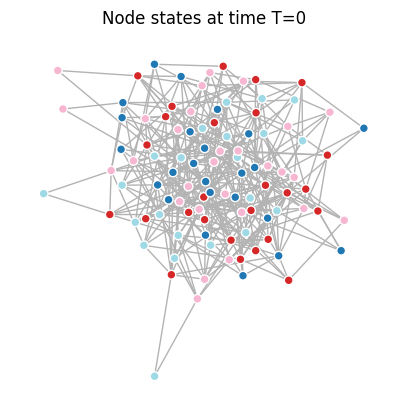

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=100)
nx.draw(G_er, positions, node_size=40, edge_color='.7',
        node_color = list(nx.get_node_attributes(G_er,'state').values()),
        edgecolors='w',
        vmin=0, vmax=number_of_opinions-1, cmap=plt.cm.tab20,ax=ax)


ax.set_title('Node states at time T=0')

plt.show()

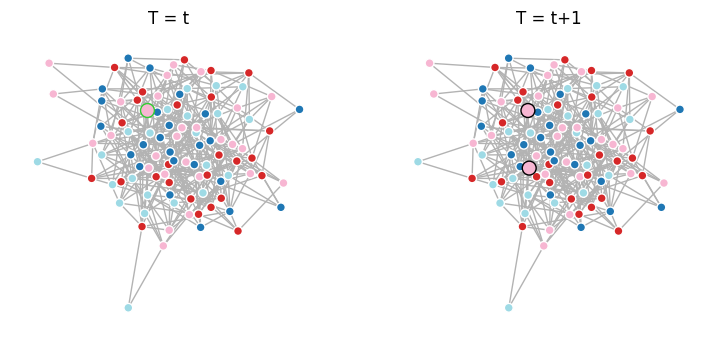

In [7]:
# One step of the voter model simulation
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=100)


# Randomly select a "listener" node from the graph.
# The "listener" is the agent whose state may change in this step.
listener = np.random.choice(G_er.nodes())

nx.draw(G_er, positions, node_size=[40 if i!=listener else 100 for i in G_er.nodes()],
        edge_color='.7',
        node_color=[G_er.nodes[n]['state'] for n in G_er.nodes()],
        edgecolors=['w' if i!=listener else 'limegreen' for i in G_er.nodes()],
        vmin=0, vmax=number_of_opinions-1, cmap=plt.cm.tab20, ax=ax[0])


# Check if the "listener" has any neighbors (i.e., it isn't isolated).
# The voter model requires interaction between neighbors, so no update is possible if there are none.
if list(G_er.neighbors(listener)) != []:
    
    # Randomly select a "speaker" node from the neighbors of the "listener."
    # The "speaker" is the agent influencing the "listener's" state in this step.
    speaker = np.random.choice(list(G_er.neighbors(listener)))
    
    # Update the "listener's" state to match the "speaker's" state.
    # This simulates the "listener" adopting the opinion of the "speaker."
    G_er.nodes[listener]['state'] = G_er.nodes[speaker]['state']
    

nx.draw(G_er, positions, node_size=[40 if i not in [listener,speaker] else 100 for i in G_er.nodes()],
        edgecolors=['w' if i not in [listener,speaker] else 'k' for i in G_er.nodes()],
        edge_color='.7', node_color = [G_er.nodes[n]['state'] for n in G_er.nodes()],
        vmin=0, vmax=number_of_opinions-1, cmap=plt.cm.tab20, ax=ax[1])

ax[0].set_title('T = t')
ax[1].set_title('T = t+1')


plt.show()

### Your turn!

1. Wrap a single "step" into a function.
2. Create a function that runs T steps, tracking the node states through time.
3. Write a function that visualizes the evolution of this network toward consensus.

In [8]:
pass

________

In [9]:
def voter_step(G, var_name='state', p_adopt=1.0):
    """
    Executes a single step of the voter model on a graph.

    In this step, a randomly selected "listener" node may adopt the state of 
    a randomly chosen "speaker" node from its neighbors with a probability `p_adopt`.

    Args:
        G (networkx.Graph): The input graph where nodes have a `var_name` attribute
                            representing their current state.
        var_name (str): The name of the node attribute used for storing opinions or states.
                        Default is 'state'.
        p_adopt (float): The probability that the listener adopts the speaker's state
                         during an interaction. Default is 1.0 (always adopt).

    Returns:
        networkx.Graph: The updated graph after one voter model step.
    """
    # Randomly select a "listener" node from the graph
    listener = np.random.choice(G.nodes())

    # Check if the "listener" has any neighbors (skip if isolated)
    if list(G.neighbors(listener)) != []:

        # Randomly select a "speaker" node from the listener's neighbors
        speaker = np.random.choice(list(G.neighbors(listener)))

        # With probability p_adopt, the listener adopts the speaker's state
        if np.random.rand() < p_adopt:
            G.nodes[listener][var_name] = G.nodes[speaker][var_name]

    return G


def run_voter_model(G, T, number_of_opinions=4, var_name='state', p_adopt=1.0):
    """
    Simulates the voter model on a graph for a specified number of steps.

    Each node is initialized with a random opinion (from a predefined number of opinions),
    and the voter model is iteratively applied for T time steps. During each step, a randomly
    selected node (listener) may adopt the opinion of a randomly chosen neighbor (speaker).

    Args:
        G (networkx.Graph): The input graph where nodes will hold their state as a `var_name` attribute.
        T (int): The number of time steps to simulate.
        number_of_opinions (int): The total number of unique opinions to assign initially.
                                  Default is 4.
        var_name (str): The name of the node attribute used for storing opinions or states.
                        Default is 'state'.
        p_adopt (float): The probability that a listener adopts the speaker's state
                         during an interaction. Default is 1.0 (always adopt).

    Returns:
        tuple:
            - networkx.Graph: The graph with final states of nodes after T steps.
            - np.ndarray: A 2D array where rows correspond to nodes and columns correspond
                          to their state over time steps.
    """
    # Initialize node states with random opinions
    N = G.number_of_nodes()
    init_opinions = dict(zip(G.nodes(),
                             (np.random.choice(list(range(number_of_opinions)),
                                               size=N))))
    nx.set_node_attributes(G, init_opinions, name=var_name)

    # Create a copy of the graph for tracking opinion evolution
    H = G.copy()
    opinions_out = np.zeros((N, T))
    opinions_out[:, 0] = list(nx.get_node_attributes(G, name=var_name).values())

    # Run the voter model for T steps
    for t in range(1, T):
        G = voter_step(G, var_name, p_adopt)
        opinions_out[:, t] = list(nx.get_node_attributes(G, name=var_name).values())

    return G, opinions_out

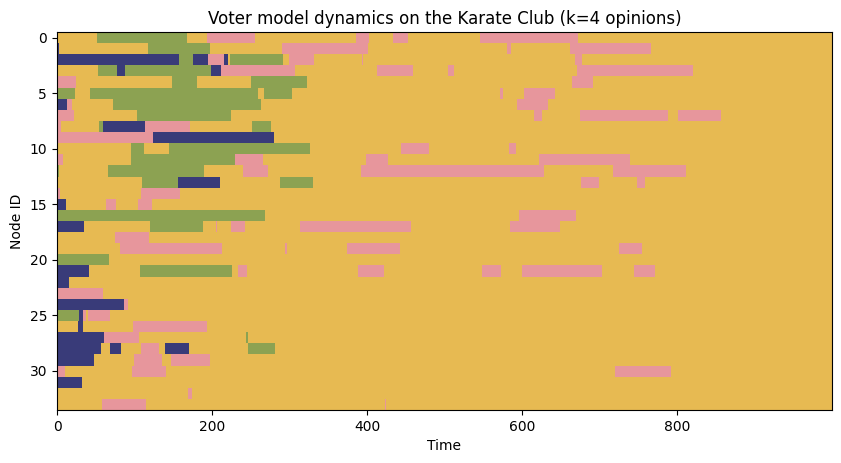

In [10]:
# np.random.seed(4)
N = 100
T = 1000
G = nx.karate_club_graph()
num_opinions = 4
Gx, op = run_voter_model(G,T,num_opinions)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=100)

ax.imshow(op, aspect='auto', cmap=plt.cm.tab20b, interpolation='none', vmin=0, vmax=num_opinions)

ax.set_title('Voter model dynamics on the Karate Club (k=%i opinions)'%len(np.unique(op)))
ax.set_xlabel('Time')
ax.set_ylabel('Node ID')

plt.show()

_______

## Schelling Model of Segregation
![](images/schelling.png)

The Schelling model was a landmark in ABMs, which really well illustrated the way that (slight!!) *individual preferences* lead to large-scale patterns of segregation. Originally introduced by Thomas Schelling in *Dynamic Models of Segregation* (1971) and later expanded in his book *Micromotives and Macrobehavior* (1978), the model captures a critical dynamic: small, individual preferences for neighbors of similar characteristics can lead to dramatic, unintended societal outcomes, such as complete segregation. It is a great example for how systems self-organize and how seemingly benign preferences can amplify into systemic inequalities. It provides a framework for studying not just segregation in housing, but also phenomena like polarization in social networks, opinion clustering, and even ecological niche formation.

While Schelling originally placed agents on a 2D grid, modern adaptations situate agents on network structures, offering new perspectives on segregation dynamics. These adaptations allow researchers to explore:
- *Topology Effects*: How network structures, such as degree distributions, clustering, and community structure, influence segregation outcomes.
- *Heterogeneity in Preferences*: Studying diverse populations with varying satisfaction thresholds to understand robustness and sensitivity of segregation dynamics.
- *Dynamic Networks*: Incorporating adaptive or rewiring mechanisms to capture real-world social and spatial dynamics.


![](images/boston_race.png)

Source: https://demographics.virginia.edu/DotMap/


**Some helpful references:**

1. Schelling, T. C. (1971). Dynamic models of segregation. *Journal of Mathematical Sociology, 1*(2), 143–186. https://doi.org/10.1080/0022250X.1971.9989794
2. Schelling, T. C. (1978). *Micromotives and Macrobehavior.* New York: W.W. Norton & Company. https://wwnorton.com/books/Micromotives-and-Macrobehavior/
3. Fossett, M. (2006). Ethnic preferences, social distance dynamics, and residential segregation: Theoretical explorations using simulation analysis. *Journal of Mathematical Sociology, 30*(3-4), 185–273. https://doi.org/10.1080/00222500500544052
4. Pancs, R., & Vriend, N. J. (2007). Schelling’s spatial proximity model of segregation revisited. *Journal of Public Economics, 91*(1-2), 1–24. https://doi.org/10.1016/j.jpubeco.2006.03.008
5. Zhang, J. (2004). Residential segregation in an all-integrationist world. *Journal of Economic Behavior & Organization, 54*(4), 533–550. https://doi.org/10.1016/j.jebo.2003.04.001
6. Grauwin, S., Goffette-Nagot, F., & Jensen, P. (2012). Dynamic models of residential segregation: An analytical solution. *Journal of Public Economics, 96*(1-2), 124–141. https://doi.org/10.1016/j.jpubeco.2011.08.011
7. Bruch, E. E., & Mare, R. D. (2006). Neighborhood choice and neighborhood change. *American Journal of Sociology, 112*(3), 667–709. https://doi.org/10.1086/507856
8. Clark, W. A. V. (1991). Residential preferences and neighborhood racial segregation: A test of the Schelling segregation model. *Demography, 28*(1), 1–19. https://doi.org/10.2307/2061333
9. Epstein, J. M., & Axtell, R. (1996). *Growing artificial societies: Social science from the bottom up.* Washington, DC: Brookings Institution Press. (on Brennan's desk if you want!)

### Implementing the Schelling model on a grid

1. Initialize grid (size, number of individuals vs empty space)
2. Initialize population
    - Number of categories
    - Proportion of nodes in each category
    - Tolerance level: [0.0-1.0], where 0.3 means that nodes need 30% of similar neighbors to be satisfied

In [11]:
# Parameters
width=100; height=100     # Size of the grid
empty_ratio = 0.2         # Percentage of empty spaces
tolerance = 0.3           # Tolerance level (0.3 means 30% similar neighbors needed to be happy)
iterations = 50           # Number of iterations

num_categories = 2

In [12]:
# Initialization
num_empty = int(width * height * empty_ratio)
num_agents = width * height - num_empty

nums_per_group = []
for i in range(num_categories):
    nums_per_group.append(num_agents // num_categories)

if num_agents - sum(nums_per_group) > 0:
    nums_per_group[-1] += num_agents - sum(nums_per_group)

In [13]:
# Create grid and place agents and empty spaces
grid = np.zeros((width, height))

agent_categories = [0] * num_empty
for ix, num_in_group in enumerate(nums_per_group):
    ix += 1
    agent_categories = agent_categories + [ix]*num_in_group

agents = np.array(agent_categories)

np.random.shuffle(agents)

grid = agents.reshape((width, height))

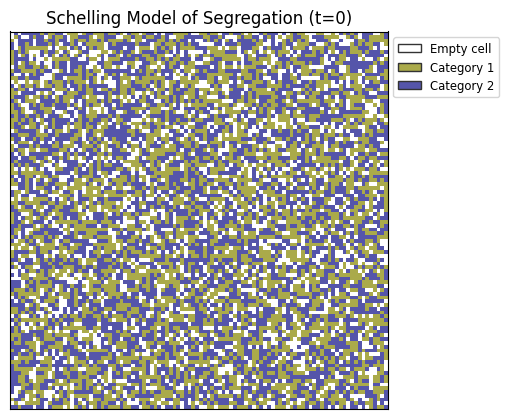

In [14]:
import matplotlib.patches as mpatches

category_labels = ['Empty cell', 'Category 1', 'Category 2']
colors = ['w', '#ffcccb', '#add8e6']  # Example colors from the colormap
colors = plt.cm.gist_stern_r(np.linspace(0,1,num_categories+2))

# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
im = ax.imshow(grid, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)

# Create legend entries
legend_patches = [mpatches.Patch(color=color, ec='.2', label=label) 
                  for color, label in zip(colors, category_labels)]
ax.legend(handles=legend_patches, loc=2, bbox_to_anchor=[1.0,1.0], fontsize='small')

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Schelling Model of Segregation (t=0)')

plt.show()

Now that this is initialized, we need functions that:

3. Evaluate whether a given cell is "satisfied", and
4. Move "unsatisfied" individuals to cells that are empty

In [15]:
def is_satisfied(grid, x, y, tolerance=0.3):
    """
    Determine whether the agent at (x, y) is satisfied under the Schelling rule.

    Parameters
    ----------
    grid : 2D array-like (ints)
        Lattice of shape (rows, cols): 0 denotes empty; positive integers
        denote agent groups/types (e.g., 1, 2, ...).
    x : int
        Row index of the focal cell.
    y : int
        Column index of the focal cell.
    tolerance : float, optional (default=0.3)
        Minimum fraction of *occupied* neighbors that must match the focal
        agent's type for the agent to be considered satisfied.

    Returns
    -------
    bool
        True if the cell is empty or the agent meets the tolerance criterion;
        False otherwise.

    Notes
    -----
    - Uses the Moore neighborhood (8 neighbors).
    - Border cells only consider in-bounds neighbors.
    - If there are no occupied neighbors, the agent is considered satisfied
      (no evidence of being "out of place").
    - This function is grid-local (no reliance on global width/height).
    """
    agent = grid[x, y]

    # Empty cells are trivially "satisfied" (nothing to move).
    if agent == 0:
        return True

    rows, cols = grid.shape

    # Collect values from the 8-neighborhood, staying in-bounds.
    neighbors = []
    for dx in (-1, 0, 1):
        for dy in (-1, 0, 1):
            if dx == 0 and dy == 0:
                continue  # skip the focal cell
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols:
                neighbors.append(grid[nx, ny])

    # Only compare against occupied neighbors.
    occupied = [val for val in neighbors if val != 0]

    # If no occupied neighbors, we treat the agent as satisfied by convention.
    if not occupied:
        return True

    like_count = sum(1 for val in occupied if val == agent)
    frac_like = like_count / len(occupied)

    return frac_like >= tolerance


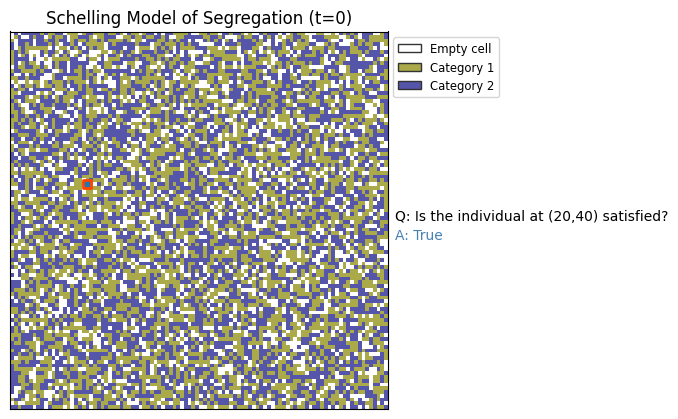

In [16]:
x=20; y=40

import matplotlib.patches as mpatches

category_labels = ['Empty cell', 'Category 1', 'Category 2']
colors = ['w', '#ffcccb', '#add8e6']  # Example colors from the colormap
colors = plt.cm.gist_stern_r(np.linspace(0,1,num_categories+2))

# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
im = ax.imshow(grid, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)

ax.scatter([x],[y],marker='s',c=None,ec='orangered',lw=2)

# Create legend entries
legend_patches = [mpatches.Patch(color=color, ec='.2', label=label) 
                  for color, label in zip(colors, category_labels)]
ax.legend(handles=legend_patches, loc=2, bbox_to_anchor=[1.0,1.0], fontsize='small')

ax.text(1.02, 0.50, "Q: Is the individual at (%i,%i) satisfied?"%(x,y),transform=ax.transAxes)
ax.text(1.02, 0.45, "A: %s"%(str(is_satisfied(grid,x,y,tolerance))),transform=ax.transAxes,color='steelblue')
# ax.text(1.02, 0.45, "A: %s"%(str(is_satisfied(x,y,tolerance))),transform=ax.transAxes,color='steelblue')

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Schelling Model of Segregation (t=0)')

plt.show()

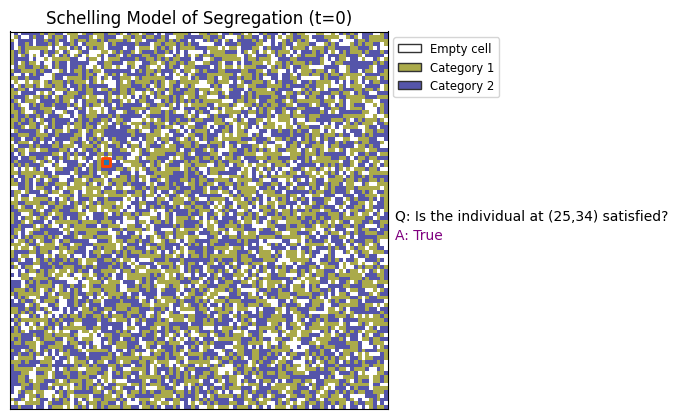

In [17]:
x=25; y=34
tol = 0.9
category_labels = ['Empty cell', 'Category 1', 'Category 2']
colors = ['w', '#ffcccb', '#add8e6']  # Example colors from the colormap
colors = plt.cm.gist_stern_r(np.linspace(0,1,num_categories+2))

# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
im = ax.imshow(grid, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)

ax.scatter([x],[y],marker='s',c=None,ec='orangered',lw=2)

# Create legend entries
legend_patches = [mpatches.Patch(color=color, ec='.2', label=label) 
                  for color, label in zip(colors, category_labels)]
ax.legend(handles=legend_patches, loc=2, bbox_to_anchor=[1.0,1.0], fontsize='small')

ax.text(1.02, 0.50, "Q: Is the individual at (%i,%i) satisfied?"%(x,y),transform=ax.transAxes)
ax.text(1.02, 0.45, "A: %s"%(str(is_satisfied(grid,x,y,tol))),transform=ax.transAxes,color='purple')
# ax.text(1.02, 0.45, "A: %s"%(str(is_satisfied(x,y,tol))),transform=ax.transAxes,color='purple')

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Schelling Model of Segregation (t=0)')

plt.show()

In [18]:
def move_unsatisfied_agents(grid, T=100, tolerance=0.3):
    """
    Moves unsatisfied agents to random empty spaces in the grid.

    Unsatisfied agents are those who do not meet the satisfaction threshold
    based on the proportion of similar neighbors. The function shuffles both
    unsatisfied agents and empty spaces, then relocates the agents to available spaces.

    Args:
        grid (np.ndarray): The 2D array representing the current state of the grid.
                           Values > 0 represent agents, and 0 represents empty spaces.
        T (int): The number of iterations to perform.
        tolerance (float): The minimum proportion of similar neighbors for an agent to be satisfied.

    Returns:
        np.ndarray: The updated grid after moving unsatisfied agents.
    """

    width = grid.shape[0]
    height = grid.shape[1]

    for _ in range(T):
        unsatisfied_agents = []
        empty_spaces = [(x, y) for x in range(width) for y in range(height) if grid[x, y] == 0]
        
        # Identify all unsatisfied agents
        for x in range(width):
            for y in range(height):
                if grid[x, y] != 0 and not is_satisfied(grid, x, y, tolerance):
#                 if grid[x, y] != 0 and not is_satisfied(x, y, tolerance):
                    unsatisfied_agents.append((x, y))
        
        # Shuffle unsatisfied agents and empty spaces for random relocation
        np.random.shuffle(unsatisfied_agents)
        np.random.shuffle(empty_spaces)
        
        # Move unsatisfied agents to random empty spots
        for (x, y), (new_x, new_y) in zip(unsatisfied_agents, empty_spaces):
            grid[new_x, new_y], grid[x, y] = grid[x, y], 0


    return grid

In [19]:
# Parameters
width, height = 100, 100  # Size of the grid
empty_ratio = 0.3         # Percentage of empty spaces
tolerance = 0.3           # Tolerance level (0.3 means 30% similar neighbors needed to be happy)
iterations = 500          # Number of iterations

num_categories = 2

# Initialization
num_empty = int(width * height * empty_ratio)
num_agents = width * height - num_empty

nums_per_group = []
for i in range(num_categories):
    nums_per_group.append(num_agents // num_categories)

if num_agents - sum(nums_per_group) > 0:
    nums_per_group[-1] += num_agents - sum(nums_per_group)
    
    
    
# Create grid and place agents and empty spaces
grid = np.zeros((width, height))

agent_categories = [0] * num_empty
for ix, num_in_group in enumerate(nums_per_group):
    ix += 1
    agent_categories = agent_categories + [ix]*num_in_group

agents = np.array(agent_categories)

np.random.shuffle(agents)

grid = agents.reshape((width, height))
grid_0 = grid.copy()

grid_t = move_unsatisfied_agents(grid, T=iterations, tolerance=tolerance)

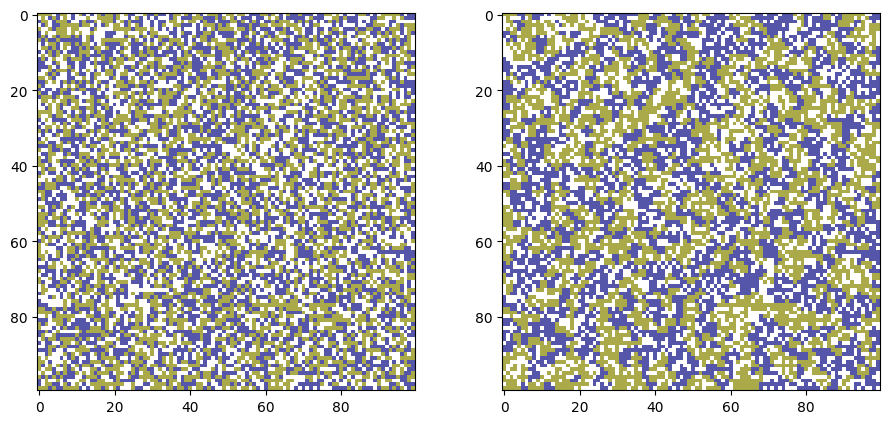

In [20]:
fig, ax = plt.subplots(1,2,figsize=(11,5),dpi=100)

ax[0].imshow(grid_0, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)
ax[1].imshow(grid_t, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)

plt.show()

In [21]:
# Parameters
width, height = 100, 100  # Size of the grid
empty_ratio = 0.25         # Percentage of empty spaces
tolerance = 0.8           # Tolerance level (0.3 means 30% similar neighbors needed to be happy)
iterations = 500           # Number of iterations

num_categories = 2

# Initialization
num_empty = int(width * height * empty_ratio)
num_agents = width * height - num_empty

nums_per_group = []
for i in range(num_categories):
    nums_per_group.append(num_agents // num_categories)

if num_agents - sum(nums_per_group) > 0:
    nums_per_group[-1] += num_agents - sum(nums_per_group)
    
    
    
# Create grid and place agents and empty spaces
grid = np.zeros((width, height))

agent_categories = [0] * num_empty
for ix, num_in_group in enumerate(nums_per_group):
    ix += 1
    agent_categories = agent_categories + [ix]*num_in_group

agents = np.array(agent_categories)

np.random.shuffle(agents)

grid = agents.reshape((width, height))
grid_0 = grid.copy()

grid_t = move_unsatisfied_agents(grid, T=iterations, tolerance=tolerance)

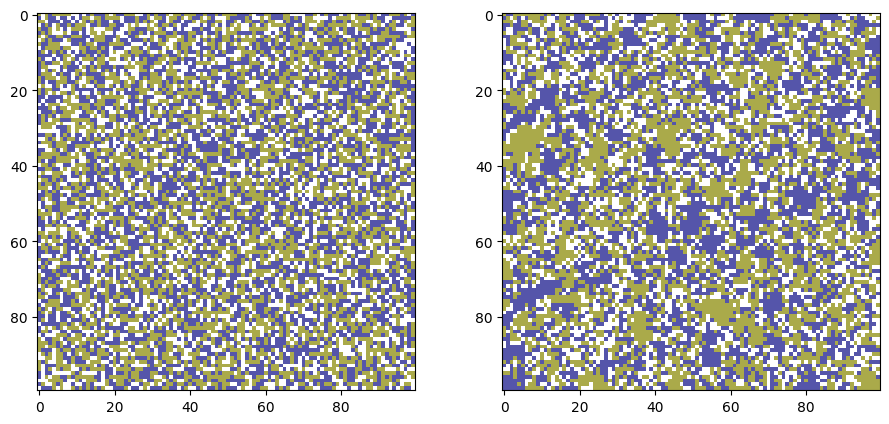

In [22]:
fig, ax = plt.subplots(1,2,figsize=(11,5),dpi=100)

ax[0].imshow(grid_0, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)
ax[1].imshow(grid_t, cmap='gist_stern_r', interpolation='none',
               vmin=0, vmax=num_categories+1)

plt.show()

### What about a networkx-ified version?

In [23]:
def initialize_environment(width=100, height=100, empty_ratio=0.3,
                           num_categories=2, var_name='state'):
    """
    Initializes a NetworkX graph-based environment for the Schelling model.

    The environment consists of a grid where each node represents a cell that is either:
    - Empty (state 0)
    - Occupied by an agent from one of the given categories (state > 0)

    Agents are distributed randomly, and the number of agents per category is balanced.

    Args:
        width (int): The width of the grid.
        height (int): The height of the grid.
        empty_ratio (float): The percentage of cells that are empty (value between 0 and 1).
        num_categories (int): The number of agent categories (e.g., groups).

    Returns:
        networkx.Graph: A 2D grid graph with nodes having a "state" attribute indicating
                        whether the node is empty or occupied by an agent from a specific category.
    """

    # Create the grid graph
    G = nx.grid_2d_graph(width, height)
    node_pos = list(G.nodes())
    node_ids = list(range(G.number_of_nodes()))
    G = nx.relabel_nodes(G, dict(zip(node_pos,node_ids)))
    nx.set_node_attributes(G, 0, var_name)  # Default state for all nodes is 0 (empty)
    nx.set_node_attributes(G, dict(zip(node_ids,node_pos)), 'pos')

    # Calculate the number of empty cells and agents
    num_empty = int(width * height * empty_ratio)
    num_agents = width * height - num_empty

    # Distribute agents among categories
    nums_per_group = [num_agents // num_categories] * num_categories
    if num_agents - sum(nums_per_group) > 0:
        nums_per_group[-1] += num_agents - sum(nums_per_group)

    # Create agent categories and shuffle
    agent_categories = [0] * num_empty  # Empty spaces
    for ix, num_in_group in enumerate(nums_per_group):
        agent_categories += [ix + 1] * num_in_group  # Agents are 1, 2, ...
    np.random.shuffle(agent_categories)

    # Assign shuffled agents to the nodes in the grid
    for idx, node in enumerate(G.nodes):
        G.nodes[node][var_name] = agent_categories[idx]

    return G


# Helper function to check satisfaction
def is_satisfied_nx(G, node, tolerance, var_name='state', empty_neighbor=False):
    """
    Determines if a node is satisfied based on its neighborhood in the graph.

    Args:
        G (networkx.Graph): The (not-necessarily-grid) graph containing nodes with a
            categorical attribute `var_name`. Convention: 0 denotes empty.
        node: The node to check (e.g., a (x, y) tuple for grid graphs or any node label).
        tolerance (float): Minimum proportion of similar neighbors required for satisfaction.
        var_name (str, optional): Node attribute name holding the agent's state. Default 'state'.
        empty_neighbor (bool, optional): If True, exclude empty neighbors (state == 0)
            from the denominator (i.e., empties are neutral). If False, use total degree
            in the denominator (empties count as neighbors). Default False.

    Returns:
        bool: True if the node is satisfied under the chosen rule; False otherwise.

    Notes:
        - Empty nodes (state == 0) are always considered satisfied (nothing to move).
        - Isolated occupied nodes (degree == 0) are treated as satisfied by convention.
        - When empty_neighbor=True, the denominator counts only non-empty neighbors.
          If there are no non-empty neighbors, the node is considered satisfied.
        - When empty_neighbor=False, the denominator is the node's degree. This means
          empty neighbors *do* reduce the similarity fraction.
    """
    agent_state = G.nodes[node].get(var_name, 0)

    # Empty nodes are trivially satisfied.
    if agent_state == 0:
        return True

    neighbors = list(G.neighbors(node))
    deg = len(neighbors)

    # If the node is isolated, treat as satisfied by convention.
    if deg == 0:
        return True

    # Count similar neighbors (same non-zero state).
    similar_neighbors = sum(
        1 for n in neighbors if G.nodes[n].get(var_name, 0) == agent_state
    )

    if empty_neighbor:
        # Exclude empty neighbors from the denominator.
        nonempty_neighbors = sum(
            1 for n in neighbors if G.nodes[n].get(var_name, 0) != 0
        )
        # No non-empty neighbors ⇒ satisfied.
        if nonempty_neighbors == 0:
            return True
        total = nonempty_neighbors
    else:
        # Use total degree as denominator (empties count).
        total = deg

    return (similar_neighbors / total) >= tolerance


# Function to move unsatisfied agents
def move_unsatisfied_agents_nx(G, iterations, tolerance, var_name='state',
                               empty_neighbor=False, seed=None):
    """
    Moves unsatisfied agents to random empty spaces in the graph.

    Args:
        G (networkx.Graph): The graph.
        iterations (int): Number of sweeps (iterations) to perform.
        tolerance (float): Minimum proportion of similar neighbors for satisfaction.
        var_name (str): Node attribute for state (0 = empty, 1..K = groups).
        empty_neighbor (bool): If True, ignore empty neighbors in satisfaction check.
        seed (int or None): RNG seed for reproducibility.

    Returns:
        H (networkx.Graph): Updated graph.
        out_states (ndarray, shape [N, iterations]): State of each node per iteration,
            with rows ordered by the fixed `nodes_order` captured at t=0.
    """
    rng = np.random.default_rng(seed)
    H = G.copy()

    nodes_order = list(H.nodes())

    # Preallocate and record t=0
    N = H.number_of_nodes()
    out_states = np.zeros((N, iterations), dtype=int)
    out_states[:, 0] = [H.nodes[n][var_name] for n in nodes_order]

    for t in range(1, iterations):
        # Identify empties and unsatisfied agents
        empty_spaces = [n for n in nodes_order if H.nodes[n][var_name] == 0]
        unsatisfied_agents = [
            n for n in nodes_order
            if H.nodes[n][var_name] != 0
            and not is_satisfied_nx(H, n, tolerance, var_name=var_name, empty_neighbor=empty_neighbor)
        ]

        # Early stop if nothing to do
        if not unsatisfied_agents:
            out_states[:, t:] = out_states[:, t-1][:, None]
            break

        # Shuffle with RNG (reproducible if seed is set)
        rng.shuffle(unsatisfied_agents)
        rng.shuffle(empty_spaces)

        # Move as many agents as there are empty slots
        for agent, empty in zip(unsatisfied_agents, empty_spaces):
            H.nodes[empty][var_name] = H.nodes[agent][var_name]
            H.nodes[agent][var_name] = 0

        # Record snapshot using the same node order
        out_states[:, t] = [H.nodes[n][var_name] for n in nodes_order]


    return H, out_states

#### Let's explore different Schelling Model builds...

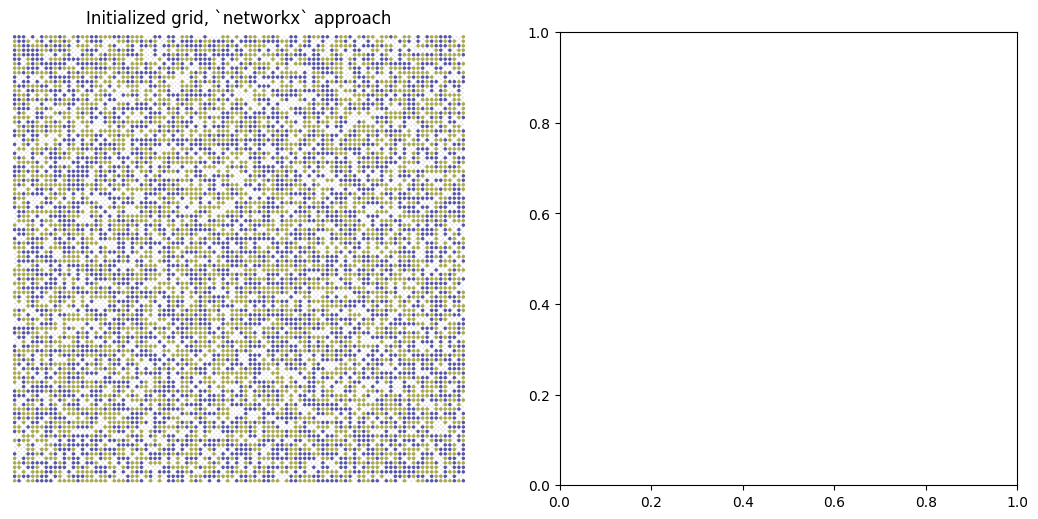

In [24]:
# Parameters
width, height = 100, 100  # Size of the grid
empty_ratio = 0.25         # Percentage of empty spaces
tolerance = 0.8           # Tolerance level (0.3 means 30% similar neighbors needed to be happy)
iterations = 500           # Number of iterations

num_categories = 2

width = 100; height = 100
empty_ratio = 0.25
tol = 0.5
iterations = 50
num_categories = 2

G = initialize_environment(width, height, empty_ratio, num_categories)
pos = nx.get_node_attributes(G, 'pos')
node_colors = list(nx.get_node_attributes(G, 'state').values())


fig, ax = plt.subplots(1,2,figsize=(13,6),dpi=100)

nx.draw_networkx_nodes(G, pos, ax=ax[0], node_size=2, node_color=node_colors,
                       cmap='gist_stern_r', vmin=0, vmax=num_categories+1)
nx.draw_networkx_edges(G, pos, ax=ax[0], width=0.15)
ax[0].set_xlim(-1,width)
ax[0].set_ylim(-1,height)
ax[0].set_title('Initialized grid, `networkx` approach')
ax[0].set_axis_off()



plt.show()

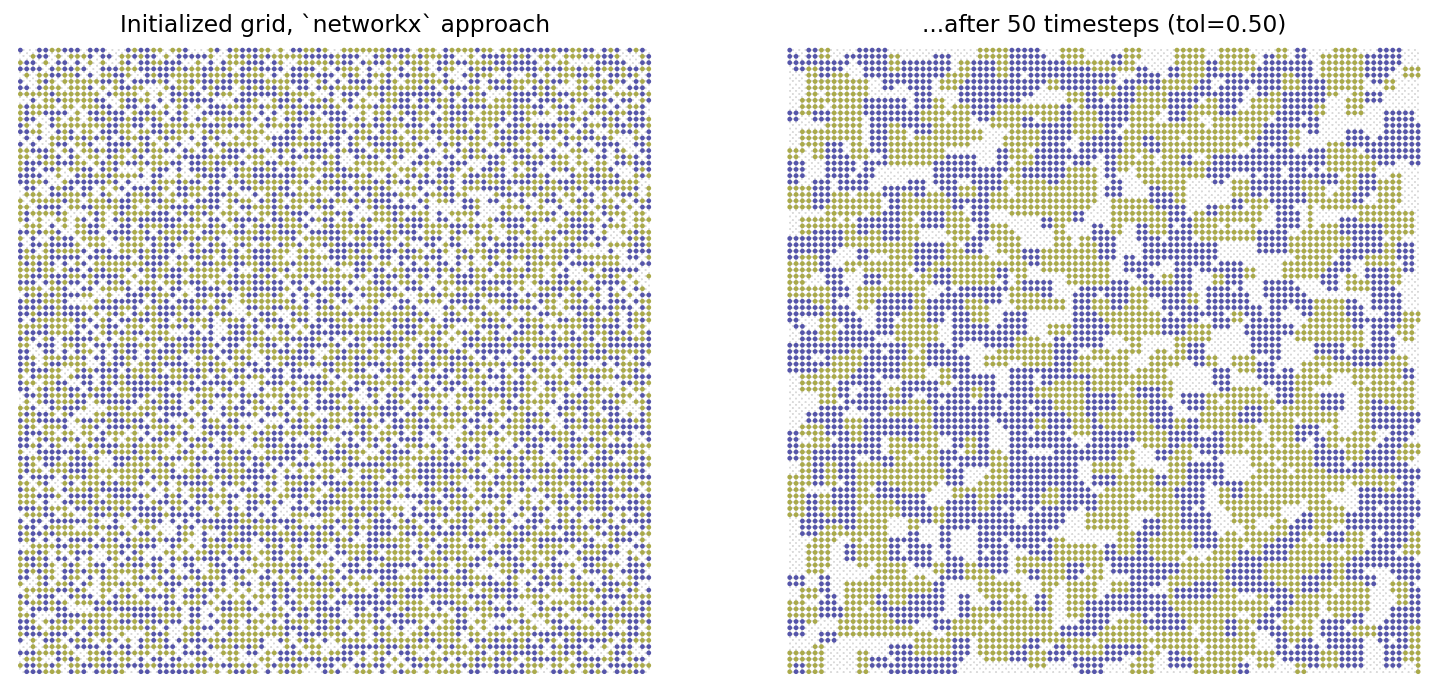

In [25]:
width = 100; height = 100
empty_ratio = 0.2
tol = 0.5
iterations = 50
num_categories = 2

G = initialize_environment(width, height, empty_ratio, num_categories)
pos = nx.get_node_attributes(G, 'pos')
node_colors = list(nx.get_node_attributes(G, 'state').values())

Gt, op = move_unsatisfied_agents_nx(G, iterations, tol, var_name='state')


fig, ax = plt.subplots(1,2,figsize=(13,6),dpi=100)

nx.draw_networkx_nodes(G, pos, ax=ax[0], node_size=2, node_color=node_colors,
                       cmap='gist_stern_r', vmin=0, vmax=num_categories+1)
nx.draw_networkx_edges(G, pos, ax=ax[0], width=0.15)
ax[0].set_xlim(-1,width)
ax[0].set_ylim(-1,height)
ax[0].set_title('Initialized grid, `networkx` approach')
ax[0].set_axis_off()

node_colors = list(nx.get_node_attributes(Gt, 'state').values())

nx.draw_networkx_nodes(Gt, pos, ax=ax[1], node_size=2, node_color=node_colors,
                       cmap='gist_stern_r', vmin=0, vmax=num_categories+1)
nx.draw_networkx_edges(Gt, pos, ax=ax[1], width=0.15)
ax[1].set_xlim(-1,width)
ax[1].set_ylim(-1,height)
ax[1].set_title('...after %i timesteps (tol=%.2f)'%(iterations,tol))
ax[1].set_axis_off()


plt.show()

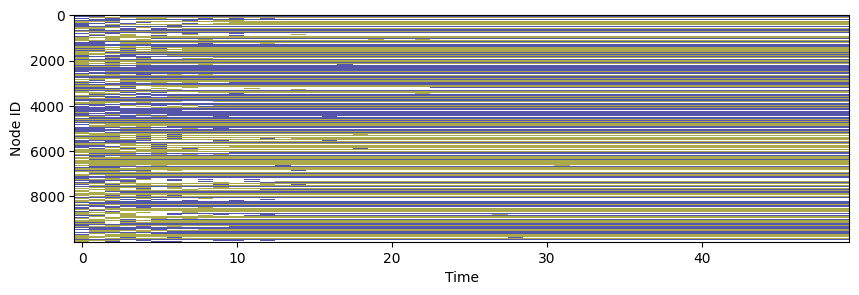

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,3),dpi=100)

ax.imshow(op, aspect='auto', vmin=0, vmax=3, interpolation='none', cmap='gist_stern_r')
ax.set_ylabel('Node ID')
ax.set_xlabel('Time')

plt.show()

#### If there's time: How do we quantify segregation using this?

In [27]:
width = 100; height = 100
empty_ratio = 0.2
tol = 0.5
iterations = 50
num_categories = 2

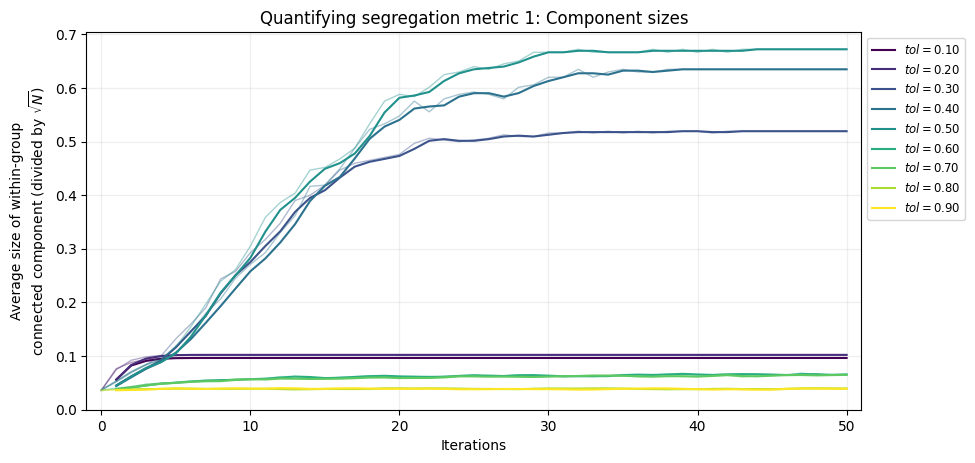

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=100)

tols = np.arange(0.1,1,0.1)
tol_cols = plt.cm.viridis(np.linspace(0,1,len(tols)))
for x,tol in enumerate(tols):
    G = initialize_environment(width, height, empty_ratio, num_categories)
    Gt, op = move_unsatisfied_agents_nx(G, iterations, tol, var_name='state')

    csizes = []
    for i in range(op.shape[1]):
        Gx = G.copy()
        nx.set_node_attributes(Gx, dict(zip(list(Gx.nodes()),op[:,i])), 'state')

        nbunch1 = [i[0] for i in Gx.nodes(data=True) if i[1]['state']==1]
        csize1 = [len(i) for i in list(nx.connected_components(nx.subgraph(Gx, nbunch=nbunch1)))]
        nbunch2 = [i[0] for i in Gx.nodes(data=True) if i[1]['state']==2]
        csize2 = [len(i) for i in list(nx.connected_components(nx.subgraph(Gx, nbunch=nbunch2)))]

        csizes.append(np.mean(csize1+csize2)/(Gx.number_of_nodes()**0.5))

    csizes.append(csizes[-1])
    ax.plot(pd.Series(csizes),color=tol_cols[x], alpha=0.4, lw=1)
    ax.plot(pd.Series(csizes).rolling(window=2, center=True).mean(),
            color=tol_cols[x], label=r'$tol=%.2f$'%tol)

ax.legend(loc=2, bbox_to_anchor=[1.0,1.0], fontsize='small')
ax.set_xlabel('Iterations')
ax.set_ylabel('Average size of within-group\n'+r'connected component (divided by $\sqrt{N}$)')
ax.set_ylim(0)
ax.set_xlim(-1,iterations+1)
ax.grid(lw=1,color='.8',alpha=0.3)
ax.set_title('Quantifying segregation metric 1: Component sizes')

plt.savefig('images/pngs/schelling_segregation_metric1.png',dpi=425,bbox_inches='tight')
plt.savefig('images/pdfs/schelling_segregation_metric1.pdf',bbox_inches='tight')

plt.show()

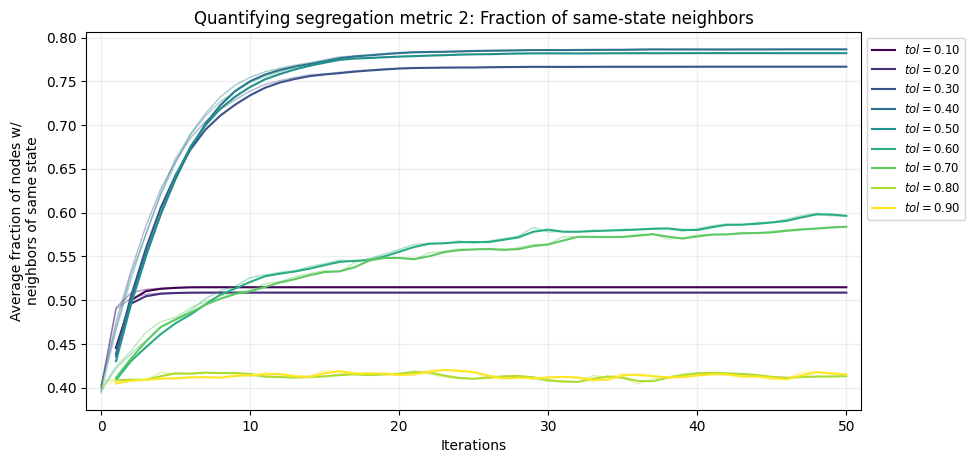

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=100)

tols = np.arange(0.1,1,0.1)
tol_cols = plt.cm.viridis(np.linspace(0,1,len(tols)))
for x,tol in enumerate(tols):
    G = initialize_environment(width, height, empty_ratio, num_categories)
    Gt, op = move_unsatisfied_agents_nx(G, iterations, tol, var_name='state')

    fracs_out = []
    for i in range(op.shape[1]):
        Gx = G.copy()
        nx.set_node_attributes(Gx, dict(zip(list(Gx.nodes()),op[:,i])), 'state')
        fracs = []

        for ix, node in enumerate(Gx.nodes()):
            node_state_i = op[:,i][node]
            if node_state_i > 0:
                node_neighbors = list(Gx.neighbors(node))
                neighbor_states = [op[:,i][nei] for nei in node_neighbors]
                same_neis = sum([1 for i in neighbor_states if i==node_state_i])
                fracs.append(same_neis/len(neighbor_states))

        fracs_out.append(np.mean(fracs))

    fracs_out.append(fracs_out[-1])
    ax.plot(pd.Series(fracs_out),color=tol_cols[x], alpha=0.4, lw=1)
    ax.plot(pd.Series(fracs_out).rolling(window=2, center=True).mean(),
            color=tol_cols[x], label=r'$tol=%.2f$'%tol)


ax.legend(loc=2, bbox_to_anchor=[1.0,1.0], fontsize='small')
ax.set_xlabel('Iterations')
ax.set_ylabel('Average fraction of nodes w/\nneighbors of same state')
ax.set_xlim(-1,iterations+1)
ax.grid(lw=1,color='.8',alpha=0.3)
ax.set_title('Quantifying segregation metric 2: Fraction of same-state neighbors')

plt.savefig('images/pngs/schelling_segregation_metric2.png',dpi=425,bbox_inches='tight')
plt.savefig('images/pdfs/schelling_segregation_metric2.pdf',bbox_inches='tight')

plt.show()

__________
## Next time...
Graph Distances `class_19_graphdistance.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://network-science-data-and-models.github.io/phys7332_fa25/README.html
    - Github: https://github.com/network-science-data-and-models/phys7332_fa25/
    - Syllabus and course details: https://brennanklein.com/phys7332-fall25
2. Clifford, P., & Sudbury, A. (1973). A model for spatial conflict. *Biometrika*, 60(3), 581–588. https://doi.org/10.1093/biomet/60.3.581
3. Holley, R. A., & Liggett, T. M. (1975). Ergodic theorems for weakly interacting infinite systems and the voter model. *Annals of Probability*, 3(4), 643–663. https://doi.org/10.1214/aop/1176996306
4. DeGroot, M. H. (1974). Reaching a consensus. Journal of the American Statistical Association, 69(345), 118–121. https://doi.org/10.2307/2285509
5. Hegselmann, R., & Krause, U. (2002). Opinion dynamics and bounded confidence: Models, analysis, and simulation. *Journal of Artificial Societies and Social Simulation, 5*(3), 1–24. http://jasss.soc.surrey.ac.uk/5/3/2.html
6. Daley, D. J., & Kendall, D. G. (1965). Stochastic rumours. *Journal of the Institute of Mathematics and Its Applications, 1*(1), 42–55. https://doi.org/10.1093/imamat/1.1.42
7. Nowak, M. A., & May, R. M. (1992). Evolutionary games and spatial chaos. *Nature, 359*(6398), 826–829. https://doi.org/10.1038/359826a0
8. Santos, F. C., & Pacheco, J. M. (2005). Scale-free networks provide a unifying framework for the emergence of cooperation. *Physical Review Letters, 95*(9), 098104. https://doi.org/10.1103/PhysRevLett.95.098104
9. Hardin, G. (1968). The tragedy of the commons. *Science, 162*(3859), 1243–1248. https://doi.org/10.1126/science.162.3859.1243
10. Perc, M., & Szolnoki, A. (2010). Coevolutionary games—a mini review. *BioSystems, 99*(2), 109–125. https://doi.org/10.1016/j.biosystems.2009.10.003
11. Güth, W., Schmittberger, R., & Schwarze, B. (1982). An experimental analysis of ultimatum bargaining. *Journal of Economic Behavior & Organization, 3*(4), 367–388. https://doi.org/10.1016/0167-2681(82)90011-7
12. Barthélemy, M. (2011). Spatial networks. *Physics Reports, 499*(1-3), 1–101. https://doi.org/10.1016/j.physrep.2010.11.002
13. Noh, J. D., & Rieger, H. (2004). Random walks on complex networks. *Physical Review Letters, 92*(11), 118701. https://doi.org/10.1103/PhysRevLett.92.118701
14. Axelrod, R. (1997). The dissemination of culture: A model with local convergence and global polarization. *Journal of Conflict Resolution, 41*(2), 203–226. https://doi.org/10.1177/0022002797041002001
15. Pariser, E. (2011). *The Filter Bubble: What the Internet Is Hiding from You.* New York: Penguin Press.
16. Dandekar, P., Goel, A., & Lee, D. T. (2013). Biased assimilation, homophily, and the dynamics of polarization. *Proceedings of the National Academy of Sciences, 110*(15), 5791–5796. https://doi.org/10.1073/pnas.1217220110
17. Bonabeau, E., Dorigo, M., & Theraulaz, G. (1999). Swarm intelligence: From natural to artificial systems. *Oxford University Press*.
18. Goss, S., Aron, S., Deneubourg, J. L., & Pasteels, J. M. (1989). Self-organized shortcuts in the Argentine ant. *Naturwissenschaften, 76*(12), 579–581. https://doi.org/10.1007/BF00462870
19. March, J. G. (1991). Exploration and exploitation in organizational learning. *Organization Science, 2*(1), 71–87. https://doi.org/10.1287/orsc.2.1.71
20. Sinervo, B., & Lively, C. M. (1996). The rock–paper–scissors game and the evolution of alternative male strategies. *Nature, 380*(6571), 240–243. https://doi.org/10.1038/380240a0
21. Epstein, J. M., & Axtell, R. (1996). *Growing artificial societies: Social science from the bottom up.* Washington, DC: Brookings Institution Press.
22. Nowak, M. A. (2006). *Evolutionary dynamics: Exploring the equations of life.* Cambridge, MA: Harvard University Press.
23. Schelling, T. C. (1971). Dynamic models of segregation. *Journal of Mathematical Sociology, 1*(2), 143–186. https://doi.org/10.1080/0022250X.1971.9989794
24. Schelling, T. C. (1978). *Micromotives and Macrobehavior.* New York: W.W. Norton & Company. https://wwnorton.com/books/Micromotives-and-Macrobehavior/
25. Fossett, M. (2006). Ethnic preferences, social distance dynamics, and residential segregation: Theoretical explorations using simulation analysis. *Journal of Mathematical Sociology, 30*(3-4), 185–273. https://doi.org/10.1080/00222500500544052
26. Pancs, R., & Vriend, N. J. (2007). Schelling’s spatial proximity model of segregation revisited. *Journal of Public Economics, 91*(1-2), 1–24. https://doi.org/10.1016/j.jpubeco.2006.03.008
27. Zhang, J. (2004). Residential segregation in an all-integrationist world. *Journal of Economic Behavior & Organization, 54*(4), 533–550. https://doi.org/10.1016/j.jebo.2003.04.001
28. Grauwin, S., Goffette-Nagot, F., & Jensen, P. (2012). Dynamic models of residential segregation: An analytical solution. *Journal of Public Economics, 96*(1-2), 124–141. https://doi.org/10.1016/j.jpubeco.2011.08.011
29. Bruch, E. E., & Mare, R. D. (2006). Neighborhood choice and neighborhood change. *American Journal of Sociology, 112*(3), 667–709. https://doi.org/10.1086/507856
30. Clark, W. A. V. (1991). Residential preferences and neighborhood racial segregation: A test of the Schelling segregation model. *Demography, 28*(1), 1–19. https://doi.org/10.2307/2061333
31. Epstein, J. M., & Axtell, R. (1996). *Growing artificial societies: Social science from the bottom up.* Washington, DC: Brookings Institution Press. (on Brennan's desk if you want!)